In [1]:
import jax
import jax.numpy as jnp 
import jax.random as jr
import optax

import sbgm

This is a simple out-of-the-box example. We'll make a dataset from a collection of arrays.

In [2]:
from data.utils import dataset_from_tensors

key = jr.key(0)
key, key_X, key_model, key_train = jr.split(key, 4)

n_channels = 1
n_pix = 32
parameter_dim = 10

X = jr.normal(key, (1000, n_channels, n_pix, n_pix))
A = jnp.ones((1000, parameter_dim))

dataset = dataset_from_tensors(
    X=X, A=A, key=key, in_memory=True, name="dataset"
)

vars(dataset)

{'name': 'dataset',
 'train_dataloader': <data.utils.InMemoryDataLoader at 0x7ff862b3bfe0>,
 'valid_dataloader': <data.utils.InMemoryDataLoader at 0x7ff85409d160>,
 'data_shape': (1, 32, 32),
 'context_shape': None,
 'parameter_dim': 10,
 'process_fn': None,
 'label_fn': functools.partial(<function dataset_from_tensors.<locals>.label_fn at 0x7ff84c1cd440>, Q=None, A=Array([[1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.]], dtype=float32))}

If you want to use a dataset from HuggingFace, see here.

In [3]:
from datasets import load_dataset

EuroSAT_RGB = load_dataset("blanchon/EuroSAT_RGB").with_format("jax")

print(EuroSAT_RGB)

X = jnp.concatenate(
    [
        EuroSAT_RGB["train"]["image"], 
        EuroSAT_RGB["validation"]["image"], 
        EuroSAT_RGB["test"]["image"]
    ],
    dtype=jnp.float32
) 
X = X / 255.
X = jnp.transpose(X, (0, 3, 1, 2))
X = (X - jnp.mean(X, axis=0)) / jnp.std(X, axis=0)

A = jnp.concatenate(
    [
        EuroSAT_RGB["train"]["label"], 
        EuroSAT_RGB["validation"]["label"], 
        EuroSAT_RGB["test"]["label"]
    ],
    dtype=jnp.float32
)[:, jnp.newaxis]

print("Images / parameters shape:", X.shape, A.shape)

dataset = dataset_from_tensors(
    X=X, A=A, key=key, in_memory=False, name="satellite"
)

_, n_channels, n_pix, n_pix = X.shape
_, parameter_dim = A.shape

vars(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 16200
    })
    test: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
    validation: Dataset({
        features: ['image', 'label', 'filename'],
        num_rows: 5400
    })
})
Images / parameters shape: (27000, 3, 64, 64) (27000, 1)


{'name': 'satellite',
 'train_dataloader': <data.utils.TorchDataLoader at 0x7feea1074c80>,
 'valid_dataloader': <data.utils.TorchDataLoader at 0x7feea2121910>,
 'data_shape': (3, 64, 64),
 'context_shape': None,
 'parameter_dim': 1,
 'process_fn': None,
 'label_fn': functools.partial(<function dataset_from_tensors.<locals>.label_fn at 0x7ff86202dd00>, Q=None, A=Array([[0.],
        [0.],
        [0.],
        ...,
        [9.],
        [9.],
        [9.]], dtype=float32))}

In [4]:
# Data
dataset_name          = dataset.name 
img_shape             = (n_channels, n_pix, n_pix)

# Model (DiT)
n_heads               = 4  
embed_dim             = 128
patch_size            = 4 
depth                 = 4

# SDE
t1                    = 8.
t0                    = 0.
dt                    = 0.1
beta_integral         = lambda t: t 
weight_fn             = lambda t: 1. - jnp.exp(-beta_integral(t)) 

# Sampling
use_ema               = False
sample_size           = 5 # Squared for a grid
exact_log_prob        = False
ode_sample            = True # Sample the ODE during training
eu_sample             = True # Euler-Maruyama sample the SDE during training

# Optimisation hyperparameters
start_step            = 0
n_steps               = 200_000
batch_size            = 50 * len(jax.devices())
sample_and_save_every = 10_000
lr                    = 3e-4
opt                   = optax.adamw
opt_kwargs            = {} 

In [5]:
# Multiple GPU training if you are so inclined
sharding, replicated_sharding = sbgm.shard.get_shardings()

Running on 1 local devices: 
	[CudaDevice(id=0)]


In [6]:
model = sbgm.models.DiT(
    img_size=n_pix,
    channels=n_channels,
    embed_dim=embed_dim,
    patch_size=patch_size,
    depth=depth,
    n_heads=n_heads,
    a_dim=parameter_dim,
    key=key_model
)

sde = sbgm.sde.VPSDE(
    beta_integral_fn=beta_integral,
    dt=dt,
    t0=t0, 
    t1=t1,
    weight_fn=weight_fn
)

In [10]:
from sbgm.utils import load_model, load_opt_state

# Model and optimiser save filenames
model_filename = os.path.join(
    exp_dir, f"{dataset.name}_{config.model.model_type}.eqx"
)
state_filename = os.path.join(
    exp_dir, f"state_{dataset.name}_{config.model.model_type}.obj"
)

model = sbgm.utils.load_model(model, model_filename)
state = sbgm.utils.load_opt_state(state_filename)
opt, opt_state, start_step = state.values()

ModuleNotFoundError: No module named 'sbgm.utils'

In [ ]:
iaf

We'll only train for a small amount of time since my compute-allotment is running out...

In [ ]:
# Fit model to dataset
model = sbgm.train.train(
    key_train,
    model,
    sde,
    dataset,
    opt=opt(lr, **opt_kwargs),
    n_steps=n_steps,
    batch_size=batch_size,
    sample_size=sample_size,
    eu_sample=eu_sample,
    ode_sample=ode_sample,
    reload_opt_state=False,
    plot_train_data=True,
    sharding=sharding,
    replicated_sharding=replicated_sharding,
    save_dir="./"
)

Training SGM with a VPSDE on satellite dataset.


/project/ls-gruen/users/jed.homer/mamba-env-jax/lib/python3.12/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
2025-05-31 11:22:53.929927: F external/xla/xla/stream_executor/cuda/cuda_driver.cc:136] Non-OK-status: cuda::ToStatus(cuCtxSetCurrent(context_), "Failed setting context")
Status: INTERNAL: CUDA error: Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error
2025-05-31 11:22:53.931923: F external/xla/xla/stream_executor/cuda/cuda_driver.cc:136] Non-OK-status: cuda::ToStatus(cuCtxSetCurrent(context_), "Failed setting context")
Status: INTERNAL: CUDA error: Failed setting context: CUDA_ERROR_NOT_INITIALIZED: initialization error


RuntimeError: DataLoader worker (pid(s) 11520, 11583) exited unexpectedly

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-353.37448..304.9822].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-254.34175..233.4149].


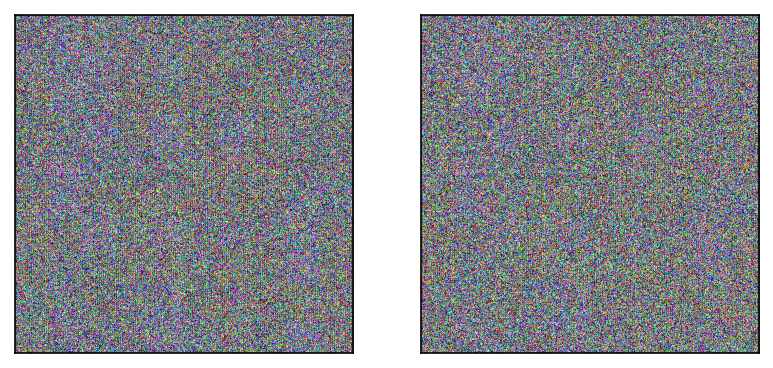

In [ ]:
import matplotlib.pyplot as plt 
from einops import rearrange

n_side = 10

key, key_Q, sample_key = jr.split(key, 3)
sample_keys = jr.split(sample_key, n_side ** 2)

# Sample random conditioning fields and P(k) parameters 
Q, A = dataset.label_fn(key_Q, n_side ** 2)

# EU sampling
sample_fn = sbgm.sample.get_eu_sample_fn(model, sde, dataset.data_shape)
eu_samples = jax.vmap(sample_fn)(sample_keys, Q, A)
# eu_samples = dataset.process_fn.reverse(eu_samples)

# ODE sampling
sample_fn = sbgm.sample.get_ode_sample_fn(model, sde, dataset.data_shape)
ode_samples = jax.vmap(sample_fn)(sample_keys, Q, A)
# ode_samples = dataset.process_fn.reverse(ode_samples)

fig, axs = plt.subplots(1, 2, dpi=150)
ax = axs[0]
ax.imshow(
    rearrange(eu_samples, "(h w) c x y -> (h x) (w y) c", h=n_side, w=n_side, x=n_pix, y=n_pix), 
)
ax = axs[1]
ax.imshow(
    rearrange(ode_samples, "(h w) c x y -> (h x) (w y) c", h=n_side, w=n_side, x=n_pix, y=n_pix)
)
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()